In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
from fedland.utils import load_all_training_results, get_experiment_description, plot_results_overview

## Experiments 5 Clients, Cifar-10, Resnet

In [2]:
df = load_all_training_results(results_path="../results")
experiment_ids = [
    "9070ebff-43ab-4eeb-9a8a-d64024ee8e04",
    "b458a5f7-193a-46f4-97d5-aac510bb5952",
    "64b57f5d-dbaf-4ffb-b9db-396ca6f73edc",
    "4b3a8ef9-c2ee-4a01-9260-6e4af635dc03",
    "410ad360-b445-4ae8-b224-6f997845a9b1",
    "3f6c270c-ff3d-4c1d-a01c-3359312cd3c4",
    "5f5b1857-84e7-4620-aa9c-77f9ea5e12da",
    "9d0054da-149f-4a8b-aa2c-6583ba8f7484",
]
df = df[df["experiment_id"].isin(experiment_ids)]
# df = df.sort_values(by=["experiment_id", "client_index", "timestamp"])
# df['iteration'] = df.groupby(['experiment_id', 'client_index']).cumcount() + 1
# df = df.reset_index()
df[["experiment_id", "client_index", "timestamp", "iteration", "epoch"]].describe()

,client_index,timestamp,iteration,epoch
count,3495.000000,3495,3495.000000,3495.000000
mean,2.000000,2024-11-26 23:02:17.341772800,44.193133,1.000000
min,0.000000,2024-11-26 14:50:56.587058,1.000000,0.000000
25%,1.000000,2024-11-26 19:16:53.807761920,22.000000,0.000000
50%,2.000000,2024-11-26 22:23:43.639868928,44.000000,1.000000
75%,3.000000,2024-11-27 03:00:57.878664448,66.000000,2.000000
max,4.000000,2024-11-27 07:36:35.847363,90.000000,2.000000
std,1.414416,NaN,25.234871,0.816613


/var/folders/wg/5g_37w5920gg12w48ly3r9qh0000gn/T/ipykernel_18592/1112684224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["pct_change_global"] = temp["global_path_norm"].pct_change()


['Resnet CIFAR-10, 5 clients, non-IID, balanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedopt']


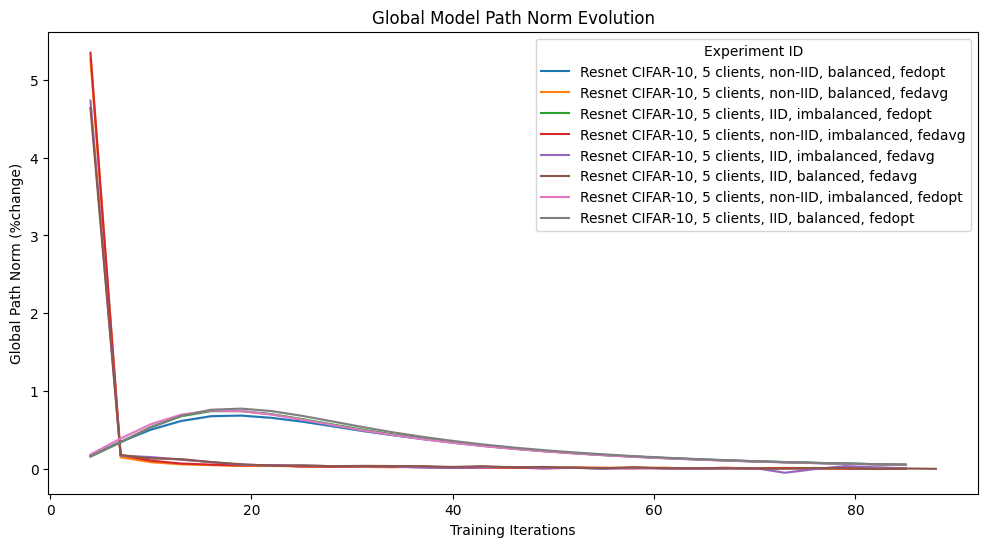

In [3]:
plt.figure(figsize=(12, 6))
temp = df[df["epoch"] == 0]
temp["pct_change_global"] = temp["global_path_norm"].pct_change()
sns.lineplot(data=temp.dropna(), x="iteration", y="pct_change_global", hue="experiment_id")
# sns.lineplot(data=df, x="iteration", y="global_path_norm", hue="experiment_id")
# for epoch_val in df[df['epoch'] == 0]['iteration']:
#     plt.axvline(x=epoch_val, color='gray', linestyle='--', alpha=0.01)
plt.title("Global Model Path Norm Evolution")
plt.xlabel("Training Iterations")
plt.ylabel("Global Path Norm (%change)")
handles, labels = plt.gca().get_legend_handles_labels()
aliased_labels = [get_experiment_description(label, "../results") for label in labels]
print(aliased_labels)
plt.legend(handles=handles, labels=aliased_labels, title="Experiment ID")
plt.show()

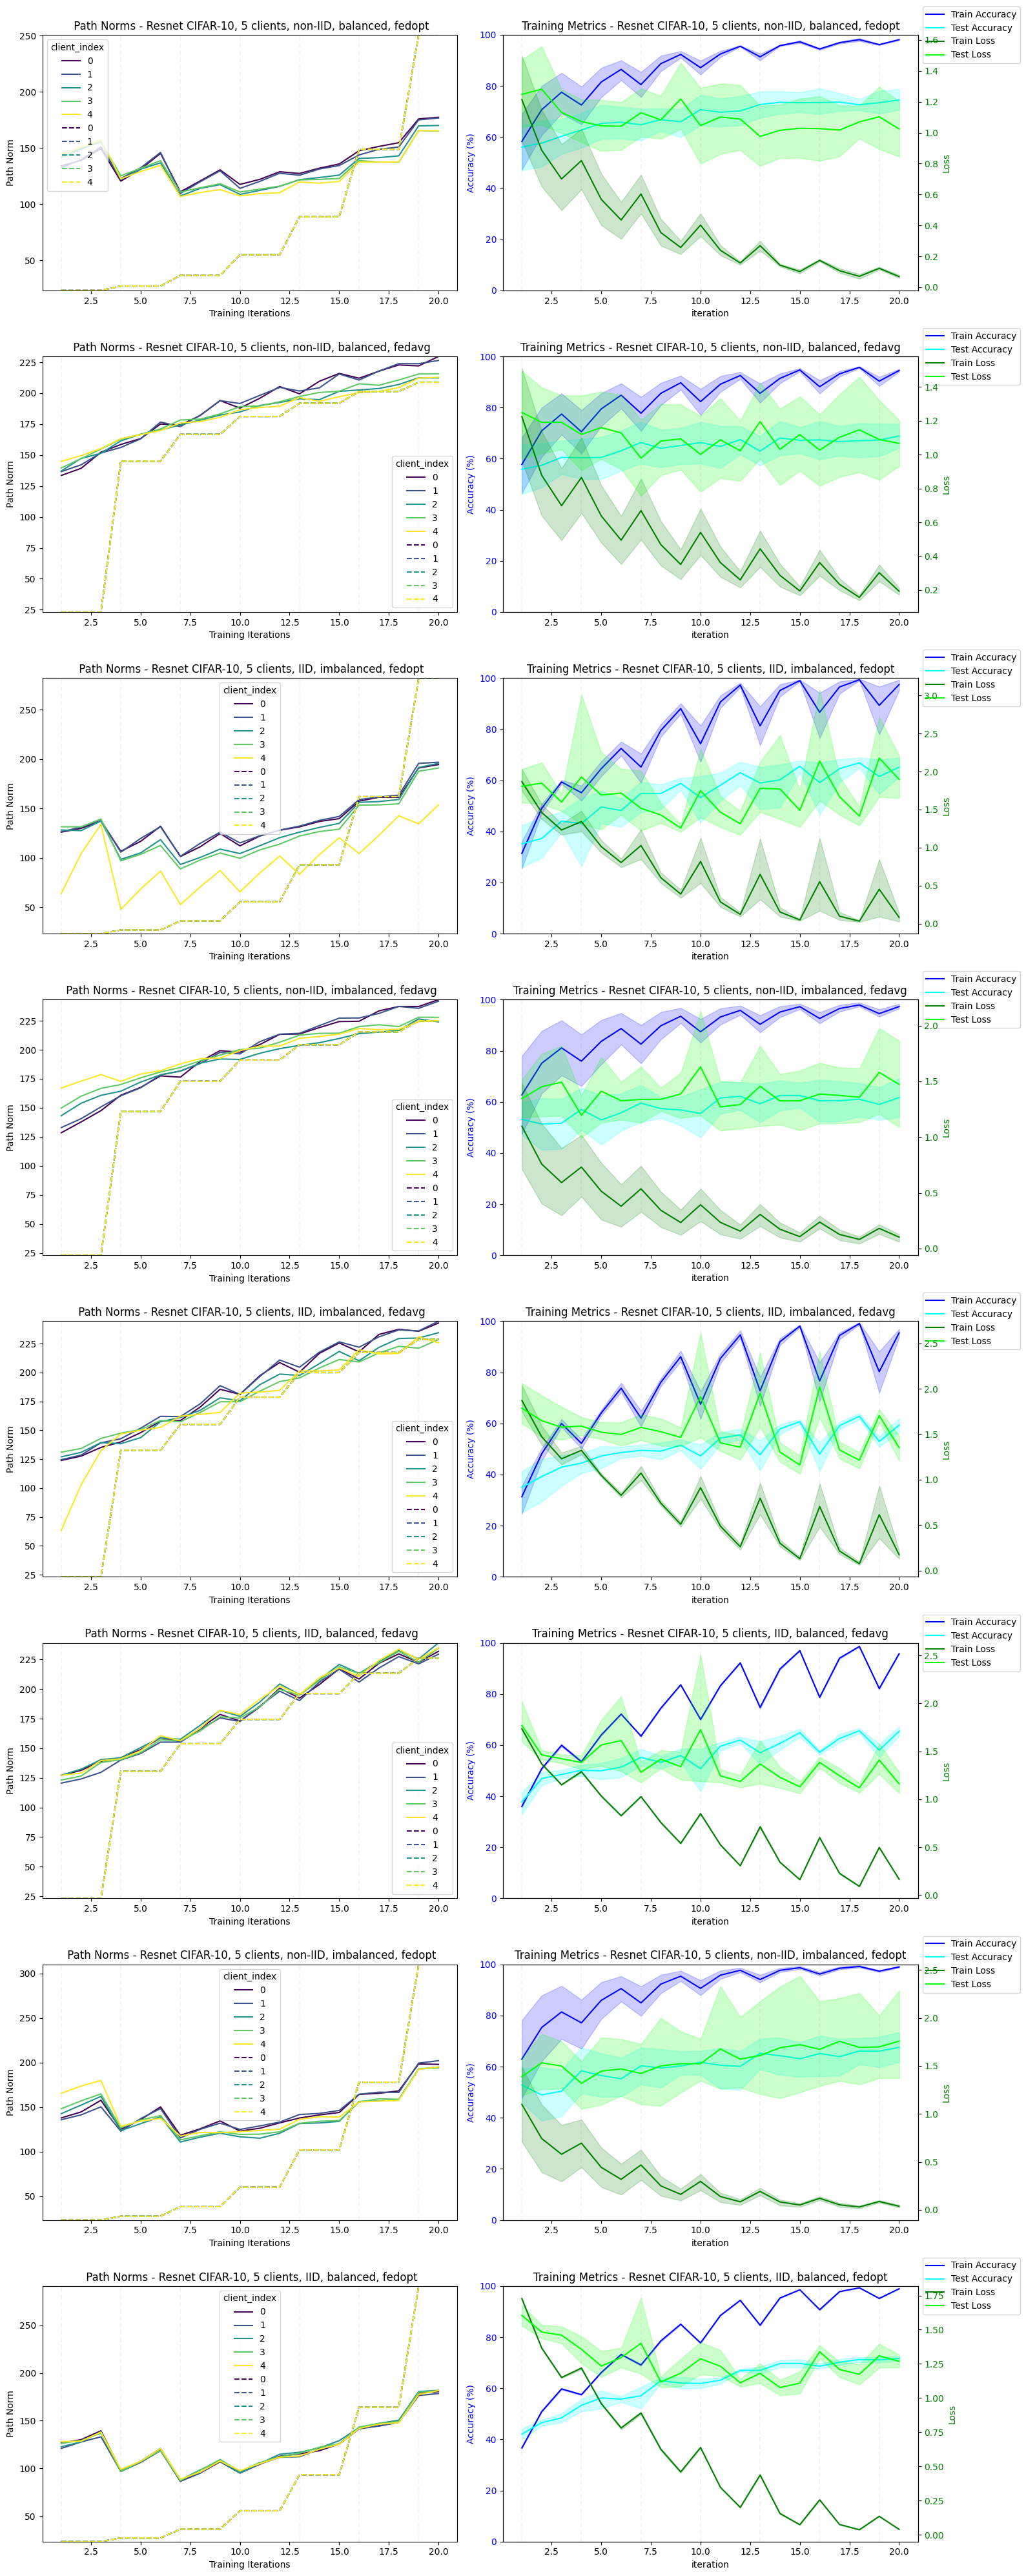

In [14]:
plot_results_overview(df, "../results", epoch=None, pct_change=False, iter_window=(0, 20))